## Dependencies

In [166]:
import re
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from autokeras import StructuredDataRegressor

In [167]:
pd.set_option("display.max_rows", None, "display.max_columns", None) # Let pandas print the entire dataframe
warnings.filterwarnings('ignore')
%matplotlib inline

## Record Correct and Mismatched Data Type

In [168]:
# Set path of train, test data
data_train_path = r'D:\pythonProject\hello_fresh_go_tasks\model_and_data\b2b_data_train - b2b_data_train.csv'
data_test_path = r'D:\pythonProject\hello_fresh_go_tasks\model_and_data\b2b_data_test - b2b_data_test.csv'


# Load csv files into pandas dataframes
df_train = pd.read_csv(data_train_path)
df_test = pd.read_csv(data_test_path)


# Label column is the one absent from test data set.
global label_col_name
label_col_name = set(df_train.columns.values) - set(df_test.columns.values)

In [169]:
# We need to first identfy the type of each column for further processing.
# We have to copy and paste the column name from the index object rather than directly from the display. 

df_column_type = df_train.dtypes.to_frame(name = 'data_type')
df_data_sample = df_train.head(2).T 
df_data_sample = df_data_sample.rename(columns = {
                                                  0:'data_sample_0',
                                                  1:'data_sample_1'
                                                  })
df_check_data_type = df_column_type.join(df_data_sample)
display(df_check_data_type)

,data_type,data_sample_0,data_sample_1
Fridge ID,int64,5370,5637
City,object,Berlin,Berlin
Location,object,Central,Fringe
Year Founded,int64,2011,2016
Maturity,object,immature,immature
Industry,object,Service,Service
IndustryNew,object,E-Commerce,"B2C Software, Apps and Digital Services"
Company Type,object,Grownup,Startup
Company Type*,object,Mature Start-Up,Growing Start-Up
Employee Type,object,White Collar,White Collar


In [170]:
# Now we pick up the columns which has the correct and wrong formats, then categorize them.  

clean_int_columns = [
    'Fridge ID',
    'Year Founded',
    'Office Size'  
] 

clean_str_columns = [
    'City',
    'Location',
    'Maturity',
    'Industry',
    'IndustryNew',
    'Company Type',
    'Company Type*', 
    'Employee Type',
    'Innercompany Location',
    'Lead Source',
    'Fridge Type'  
] 

clean_float_columns = [
    
    'Registered Users',
    'Active users (weekly average 2019 per terminal)',
    'Basket size/User/Week', 'Male/Female Ratio',
    '# Newsletter subscriptions',
    '# Fingerprints',
    '# Restaurants nearby',
    'Avg. NPS Score'  
]

# There is an unwanted 'Û' in these columns
global columns_remove_U_and_convert_str_to_float 
columns_remove_U_and_convert_str_to_float = [
    'Service Fee', 
    'Subsidy', 
    'Revenue'
]

# We have to convert the str type to float type
global columns_remove_percentage_and_convert_str_to_float
columns_remove_percentage_and_convert_str_to_float = [
    'NL/User', 
    'FP/User'
]


checked_columns = [
    clean_int_columns,
    clean_str_columns,
    clean_float_columns,
    columns_remove_U_and_convert_str_to_float,
    columns_remove_percentage_and_convert_str_to_float
]

# Verify whether we have checked all the columns
total_num_columns = len(df_train.columns) 
checked_columns = [x for xs in checked_columns for x in xs]
num_missed_column = total_num_columns - len(checked_columns)

try:
    0 == num_missed_column
    print(f'We have checked all {total_num_columns} columns')
    
except ValueError:
    raise ValueError(f"We have missed to check {num_missed_column} columns")

We have checked all 27 columns


## Correct Mismatched Data Type

In [171]:
# We create a function to wrap ip the cleaning and encoding process and apply them to both train and test set.
# i.e., we need to creat several udf for pandas dataframe, although udf is slow applied to big dataframe. 

def func_remove_U_and_convert_str_to_float(cell):
    try:
        cell = re.sub('[^0-9.]', "", cell.replace(",","."))
        return float(cell)
    except:
        return np.nan   # missing value is casted to -1.
 
def func_remove_percentage_and_convert_str_to_float(cell):
    try:
        cell = cell.replace("%","")
        return float(cell)
    
    except:   
        return np.nan
    

def apply_udf(df,columns,func):
    for col in columns:
        df[col] = df.apply(lambda x: func(x[col]),axis = 1)
        
    return df


def clean_data(df,data_type):
   
    df = apply_udf(
        df,
        columns_remove_percentage_and_convert_str_to_float,
        func_remove_percentage_and_convert_str_to_float
    )
    
    if data_type == 'train':
        df = apply_udf(
            df,
            columns_remove_U_and_convert_str_to_float,
            func_remove_U_and_convert_str_to_float
        )
    elif data_type == 'test':
        df = apply_udf(
            df,
            set(columns_remove_U_and_convert_str_to_float) - label_col_name,
            func_remove_U_and_convert_str_to_float
        )
    else:
        raise ValueError("data_type input is wrong")
    
    return df

## Check Missing Value and Fill String Valued Column

In [172]:
def get_missing_value_percentage(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
        'percent_missing': percent_missing
    })
    missing_value_df.sort_values('percent_missing', inplace=True)
    
    return missing_value_df


df_train = clean_data(df_train,'train')
df_test = clean_data(df_test,'test')

global numeric_colunms
global str_columns
numeric_colunms = set(checked_columns)\
               - set(clean_str_columns)
str_columns = clean_str_columns

global str_column_fillna_value
str_column_fillna_value = 'Unknown'

In [173]:
# We fill 'unknown' in the string valued column if the value is missing.
# we fill with the average value if the value is missing in that column.
     
        
def fill_missing_value(df,numeric_features,str_features):
    
    df_str = df[str_features]
    df_numeric = df[numeric_features]
    
    df_numeric = df_numeric.fillna(value=df_numeric.mean())
    df_str = df_str.fillna(value=str_column_fillna_value)
    df = pd.concat([df_numeric, df_str],axis=1)
    return df

## Check Correlation Between All Columns

In [174]:
# We use the whole training data to get the Heatmap matrix which gives us an overview of all pair correlations.
df_train = fill_missing_value(df_train, numeric_colunms,str_columns)   
df_test = fill_missing_value(df_test, numeric_colunms-label_col_name, str_columns) 
corr = df_train.corr()
display(corr)

,Subsidy,FP/User,NL/User,Revenue,# Newsletter subscriptions,Year Founded,Fridge ID,# Fingerprints,Basket size/User/Week,Male/Female Ratio,# Restaurants nearby,Service Fee,Office Size,Registered Users,Active users (weekly average 2019 per terminal),Avg. NPS Score
Subsidy,1.000000,0.123439,0.045030,0.273119,-0.067446,0.049700,-0.062084,-0.004526,0.195651,0.024339,-0.033123,0.088171,-0.160370,-0.073152,0.168224,0.053320
FP/User,0.123439,1.000000,0.261969,0.228317,0.041817,-0.051898,-0.187896,0.300165,0.070158,0.052112,-0.166167,-0.003535,-0.126899,-0.008235,0.201689,0.069560
NL/User,0.045030,0.261969,1.000000,0.001673,0.127295,-0.202475,0.094979,-0.073070,0.121355,-0.134380,-0.133312,0.103900,-0.036241,-0.100766,0.006375,0.225991
Revenue,0.273119,0.228317,0.001673,1.000000,0.377834,0.143770,-0.305169,0.504865,0.132400,-0.076353,-0.116038,0.025224,0.004965,0.309066,0.942982,0.108391
# Newsletter subscriptions,-0.067446,0.041817,0.127295,0.377834,1.000000,0.047212,-0.325508,0.838215,-0.274559,-0.108796,0.038703,0.078897,0.369071,0.931704,0.513393,0.147824
Year Founded,0.049700,-0.051898,-0.202475,0.143770,0.047212,1.000000,-0.037812,0.119853,-0.061810,-0.157158,0.181424,0.091055,-0.179148,0.117776,0.159023,-0.169206
Fridge ID,-0.062084,-0.187896,0.094979,-0.305169,-0.325508,-0.037812,1.000000,-0.383138,0.273732,0.074107,-0.136249,-0.032501,-0.129286,-0.330997,-0.349677,0.063821
# Fingerprints,-0.004526,0.300165,-0.073070,0.504865,0.838215,0.119853,-0.383138,1.000000,-0.262434,-0.058084,-0.020948,0.083479,0.248893,0.808139,0.619787,0.139418
Basket size/User/Week,0.195651,0.070158,0.121355,0.132400,-0.274559,-0.061810,0.273732,-0.262434,1.000000,0.071858,-0.199906,-0.087758,-0.156773,-0.271734,-0.122782,-0.002213
Male/Female Ratio,0.024339,0.052112,-0.134380,-0.076353,-0.108796,-0.157158,0.074107,-0.058084,0.071858,1.000000,-0.041986,-0.018165,0.130431,-0.090666,-0.095928,0.000287


In [175]:
# For now, we care about the correlation between the features and the to be predicted value.
# The correlation between 'Active users (weekly average 2019 per terminal)' and 'Revenue' is around 94%. 
display(df_train[df_train.columns[1:]].corr()[label_col_name][:-1].sort_values(by='Revenue',ascending=False))

,Revenue
Revenue,1.000000
Active users (weekly average 2019 per terminal),0.942982
# Fingerprints,0.504865
# Newsletter subscriptions,0.377834
Registered Users,0.309066
FP/User,0.228317
Year Founded,0.143770
Basket size/User/Week,0.132400
Service Fee,0.025224
Office Size,0.004965


<AxesSubplot:xlabel='{Revenue}', ylabel='Active users (weekly average 2019 per terminal)'>

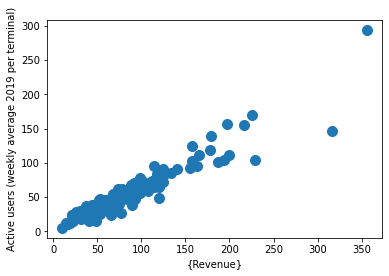

In [176]:
# Visually, we see that their relation is highly linear.
# i.e. the more the 'Active users (weekly average 2019 per terminal)' the more 'Revenue' will become.
df_train.plot.scatter(x = label_col_name, y = 'Active users (weekly average 2019 per terminal)', s = 100)

## Models: Linear Regression and XGB Regressor 

In [177]:
# We see that the relation between these two columns is highly linear (correlation is ca.94%) 
# this suggests us to build a model using 'Active users (weekly average 2019 per terminal)' to predict 'Revenue'.
# In order to avoid data leakage, we will split the data into train, validation, test and process the data again.

data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape

In [178]:
# We choose str columns with number of unique value <=7, otherwise the resulted table is too sparse
display(data[str_columns].nunique().sort_values())
global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)

Location                  2
Maturity                  2
Fridge Type               2
Company Type*             4
City                      7
Employee Type             7
Lead Source              13
IndustryNew              15
Company Type             19
Industry                 27
Innercompany Location    28
dtype: int64

In [179]:
def get_loss(model,numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]
    
    model = model.fit(X_train, y_train)
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    
    train_msr = mean_squared_error(y_train, train_y_pred)
    test_msr = mean_squared_error(y_test, test_y_pred)
    return (train_msr,test_msr)


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=10, random_state=random_state)
n = 1

train_lr_baseline_loss = 0
train_lr_positive_corr_loss = 0
train_lr_all_features_loss = 0
train_xgb_reg_loss = 0

test_lr_baseline_loss = 0
test_lr_positive_corr_loss = 0
test_lr_all_features_loss = 0
test_xgb_reg_loss = 0


for train_index, test_index in rkf.split(data):
    
    lr = LinearRegression()
    xgb_reg = XGBRegressor()
    
    lr_baseline_features = set(['Active users (weekly average 2019 per terminal)']) \
                         | label_col_name
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
                               
    
    
   
    (temp_train_lr_baseline_loss,temp_test_lr_baseline_loss) = get_loss(
        model=lr,
        numeric_features=lr_baseline_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    train_lr_baseline_loss+=temp_train_lr_baseline_loss
    test_lr_baseline_loss+=temp_test_lr_baseline_loss
    
    (temp_train_lr_positive_corr_loss,temp_test_lr_positive_corr_loss) = get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_positive_corr_loss+=temp_train_lr_positive_corr_loss
    test_lr_positive_corr_loss+=temp_test_lr_positive_corr_loss
    
    (temp_train_lr_all_features_loss,temp_test_lr_all_features_loss) = get_loss(
        model=lr,
        numeric_features=numeric_colunms,
        str_features = dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_all_features_loss+=temp_train_lr_all_features_loss
    test_lr_all_features_loss+=temp_test_lr_all_features_loss
    
    (temp_train_xgb_reg_loss,temp_test_xgb_reg_loss)= get_loss(
        model=xgb_reg,
        numeric_features=numeric_colunms,
        str_features = set([]),#dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_xgb_reg_loss+=temp_train_xgb_reg_loss
    test_xgb_reg_loss+=temp_test_xgb_reg_loss
    
    n +=1

    
print('Train:',
      '-lr base line: ',round(train_lr_baseline_loss/n), 
      '-lr more features:',round(train_lr_positive_corr_loss/n),
      '-lr all features: ', round(train_lr_all_features_loss/n),
      '-xgb reg: ', round(train_xgb_reg_loss/n)
      )

print('Test:',
      '-lr base line: ',round(test_lr_baseline_loss/n), 
      '-lr more features:',round(test_lr_positive_corr_loss/n),
      '-lr all features: ', round(test_lr_all_features_loss/n),
      '-xgb reg: ', round(test_xgb_reg_loss/n)
      )

Train: -lr base line:  314 -lr more features: 110 -lr all features:  87 -xgb reg:  0
Test: -lr base line:  360 -lr more features: 181 -lr all features:  15549692040757088256 -xgb reg:  489


## Remove Outlier in Target Value Set
Because linear regression is sensitive to outliers, after remove them we have a better result.
<br>
We remove revenue > 300 data points

In [180]:



data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape
data = data[data.Revenue<300]

global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)


def get_loss(model,numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]
    
    model = model.fit(X_train, y_train)
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    
    train_msr = mean_squared_error(y_train, train_y_pred)
    test_msr = mean_squared_error(y_test, test_y_pred)
    return (train_msr,test_msr)


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
# todo: shows that 3 can give stable train, test evaluation loss
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=3, random_state=random_state)
n = 1

train_lr_baseline_loss = 0
train_lr_positive_corr_loss = 0
train_lr_all_features_loss = 0
train_xgb_reg_loss = 0

test_lr_baseline_loss = 0
test_lr_positive_corr_loss = 0
test_lr_all_features_loss = 0
test_xgb_reg_loss = 0


for train_index, test_index in rkf.split(data):
    
    lr = LinearRegression()
    xgb_reg = XGBRegressor()
    
    lr_baseline_features = set(['Active users (weekly average 2019 per terminal)']) \
                         | label_col_name
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
                               
    
    
   
    (temp_train_lr_baseline_loss,temp_test_lr_baseline_loss) = get_loss(
        model=lr,
        numeric_features=lr_baseline_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    train_lr_baseline_loss+=temp_train_lr_baseline_loss
    test_lr_baseline_loss+=temp_test_lr_baseline_loss
    
    (temp_train_lr_positive_corr_loss,temp_test_lr_positive_corr_loss) = get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_positive_corr_loss+=temp_train_lr_positive_corr_loss
    test_lr_positive_corr_loss+=temp_test_lr_positive_corr_loss
    
    (temp_train_lr_all_features_loss,temp_test_lr_all_features_loss) = get_loss(
        model=lr,
        numeric_features=numeric_colunms,
        str_features = dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_all_features_loss+=temp_train_lr_all_features_loss
    test_lr_all_features_loss+=temp_test_lr_all_features_loss
    
    (temp_train_xgb_reg_loss,temp_test_xgb_reg_loss)= get_loss(
        model=xgb_reg,
        numeric_features=numeric_colunms,
        str_features = set([]),#dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_xgb_reg_loss+=temp_train_xgb_reg_loss
    test_xgb_reg_loss+=temp_test_xgb_reg_loss
    
    n +=1

    
print('Train:',
      '-lr base line: ',round(train_lr_baseline_loss/n), 
      '-lr more features:',round(train_lr_positive_corr_loss/n),
      '-lr all features: ', round(train_lr_all_features_loss/n),
      '-xgb reg: ', round(train_xgb_reg_loss/n)
      )

print('Test:',
      '-lr base line: ',round(test_lr_baseline_loss/n), 
      '-lr more features:',round(test_lr_positive_corr_loss/n),
      '-lr all features: ', round(test_lr_all_features_loss/n),
      '-xgb reg: ', round(test_xgb_reg_loss/n)
      )

Train: -lr base line:  215 -lr more features: 59 -lr all features:  45 -xgb reg:  0
Test: -lr base line:  227 -lr more features: 90 -lr all features:  10137293478358372352 -xgb reg:  120


## Temporary Summary of Model Performance
As we have seen that the performance before removing outlier is:
<br>
Test: -lr base line:  360 -lr more features: 181 -lr all features:  15549692040757088256 - xgb reg:  489
<br>
After removing outlier is:
<br>
Test: -lr base line:  232 -lr more features: 92 -lr all features:  11904794902809554944 - xgb reg:  119
<br>
xgb reg is 300% better than before, yet lr more features is still the best one.<br>
prediction over train set of lr all features implies that we shall not use all features, but the one from the lr more features model. 
<br>
We will give a try of autoML with autokeras (autosklearn does not support windows which is a os system.).
<br>
Useing the following commands to install.
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

## AutoMl vs. Best Model lr more feartures

In [181]:
data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape
data = data[data.Revenue<300]

global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)


def prepare_train_test(numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]
    

    return X_train,y_train,X_test,y_test


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=3, random_state=random_state)
n = 1

train_auto_ml_loss = 0
test_auto_ml_loss = 0
train_lr_positive_corr_loss = 0
test_lr_positive_corr_loss = 0


for train_index, test_index in rkf.split(data):
    
    
    lr = LinearRegression()
    
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
    
    (temp_train_lr_positive_corr_loss,temp_test_lr_positive_corr_loss) = get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    train_lr_positive_corr_loss+=temp_train_lr_positive_corr_loss
    test_lr_positive_corr_loss+=temp_test_lr_positive_corr_loss
    
    
    
    X_train,y_train,X_test,y_test = prepare_train_test(
        numeric_features=numeric_colunms,
        str_features=set([]),
        data=data,
        train_index=train_index,
        test_index=test_index)
    
    search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')
    search.fit(x=X_train, y=y_train, verbose=0)
    temp_train_auto_ml_loss,_ = search.evaluate(X_train, y_train, verbose=0)
    temp_test_auto_ml_loss,_ = search.evaluate(X_test, y_test, verbose=0)
    train_auto_ml_loss+=temp_train_auto_ml_loss
    test_auto_ml_loss+=temp_test_auto_ml_loss
    n+=1

INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/88
4/4 [==============================] - 1s 3ms/step - loss: 79.5221 - mean_squared_error: 8267.6953
Epoch 2/88
4/4 [==============================] - 0s 3ms/step - loss: 79.3314 - mean_squared_error: 8224.8086
Epoch 3/88
4/4 [==============================] - 0s 3ms/step - loss: 79.0873 - mean_squared_error: 8213.7393
Epoch 4/88
4/4 [==============================] - 0s 3ms/step - loss: 78.8203 - mean_squared_error: 8152.1382
Epoch 5/88
4/4 [==============================] - 0s 3ms/step - loss: 78.5543 - mean_squared_error: 8114.2275
Epoch 6/88
4/4 [==============================] - 0s 3ms/step - loss: 78.2491 - mean_squared_error: 8063.6572
Epoch 7/88
4/4 [==============================] - 0s 3ms/step - loss: 78.0743 - mean_squared_error: 8039.4604
Epoch 8/88
4/4 [====

Epoch 73/88
4/4 [==============================] - 0s 3ms/step - loss: 53.1653 - mean_squared_error: 4653.7661
Epoch 74/88
4/4 [==============================] - 0s 3ms/step - loss: 53.1170 - mean_squared_error: 4668.8320
Epoch 75/88
4/4 [==============================] - 0s 2ms/step - loss: 51.5310 - mean_squared_error: 4513.8203
Epoch 76/88
4/4 [==============================] - 0s 3ms/step - loss: 52.7983 - mean_squared_error: 4622.9077
Epoch 77/88
4/4 [==============================] - 0s 3ms/step - loss: 51.8178 - mean_squared_error: 4509.9126
Epoch 78/88
4/4 [==============================] - 0s 3ms/step - loss: 51.1604 - mean_squared_error: 4471.1543
Epoch 79/88
4/4 [==============================] - 0s 3ms/step - loss: 50.7913 - mean_squared_error: 4440.0444
Epoch 80/88
4/4 [==============================] - 0s 3ms/step - loss: 50.0809 - mean_squared_error: 4255.7261
Epoch 81/88
4/4 [==============================] - 0s 3ms/step - loss: 49.8679 - mean_squared_error: 4224.1934
E

4/4 [==============================] - 0s 3ms/step - loss: 65.0374 - mean_squared_error: 6491.9131
Epoch 57/88
4/4 [==============================] - 0s 3ms/step - loss: 64.3169 - mean_squared_error: 6483.0986
Epoch 58/88
4/4 [==============================] - 0s 3ms/step - loss: 63.8372 - mean_squared_error: 6346.7173
Epoch 59/88
4/4 [==============================] - 0s 3ms/step - loss: 63.3735 - mean_squared_error: 6280.3730
Epoch 60/88
4/4 [==============================] - 0s 3ms/step - loss: 62.9640 - mean_squared_error: 6191.3560
Epoch 61/88
4/4 [==============================] - 0s 3ms/step - loss: 62.2223 - mean_squared_error: 6072.8633
Epoch 62/88
4/4 [==============================] - 0s 3ms/step - loss: 62.6375 - mean_squared_error: 6177.0942
Epoch 63/88
4/4 [==============================] - 0s 3ms/step - loss: 61.9147 - mean_squared_error: 6049.5908
Epoch 64/88
4/4 [==============================] - 0s 2ms/step - loss: 60.7703 - mean_squared_error: 5907.7124
Epoch 65/88
4

4/4 [==============================] - 0s 2ms/step - loss: 70.0275 - mean_squared_error: 7042.8696
Epoch 40/88
4/4 [==============================] - 0s 3ms/step - loss: 69.5353 - mean_squared_error: 6949.4878
Epoch 41/88
4/4 [==============================] - 0s 3ms/step - loss: 69.2746 - mean_squared_error: 6917.5879
Epoch 42/88
4/4 [==============================] - 0s 3ms/step - loss: 68.9023 - mean_squared_error: 6872.9668
Epoch 43/88
4/4 [==============================] - 0s 3ms/step - loss: 68.2825 - mean_squared_error: 6778.3281
Epoch 44/88
4/4 [==============================] - 0s 3ms/step - loss: 67.9412 - mean_squared_error: 6711.2017
Epoch 45/88
4/4 [==============================] - 0s 3ms/step - loss: 67.7399 - mean_squared_error: 6682.1968
Epoch 46/88
4/4 [==============================] - 0s 3ms/step - loss: 67.2676 - mean_squared_error: 6646.8145
Epoch 47/88
4/4 [==============================] - 0s 3ms/step - loss: 66.8438 - mean_squared_error: 6560.3413
Epoch 48/88
4

5/5 [==============================] - 0s 3ms/step - loss: 73.3106 - mean_squared_error: 7354.6880
Epoch 23/88
5/5 [==============================] - 0s 2ms/step - loss: 72.5883 - mean_squared_error: 7248.8794
Epoch 24/88
5/5 [==============================] - 0s 3ms/step - loss: 72.5484 - mean_squared_error: 7228.5728
Epoch 25/88
5/5 [==============================] - 0s 3ms/step - loss: 72.2714 - mean_squared_error: 7179.9556
Epoch 26/88
5/5 [==============================] - 0s 3ms/step - loss: 71.9493 - mean_squared_error: 7163.8042
Epoch 27/88
5/5 [==============================] - 0s 2ms/step - loss: 71.4649 - mean_squared_error: 7100.2856
Epoch 28/88
5/5 [==============================] - 0s 2ms/step - loss: 71.1974 - mean_squared_error: 7030.9692
Epoch 29/88
5/5 [==============================] - 0s 2ms/step - loss: 70.8007 - mean_squared_error: 6996.0728
Epoch 30/88
5/5 [==============================] - 0s 2ms/step - loss: 70.4431 - mean_squared_error: 6935.5181
Epoch 31/88
5

5/5 [==============================] - 0s 3ms/step - loss: 76.4623 - mean_squared_error: 7926.6655
Epoch 6/88
5/5 [==============================] - 0s 2ms/step - loss: 76.2023 - mean_squared_error: 7890.3926
Epoch 7/88
5/5 [==============================] - 0s 2ms/step - loss: 76.0045 - mean_squared_error: 7848.8521
Epoch 8/88
5/5 [==============================] - 0s 3ms/step - loss: 75.6417 - mean_squared_error: 7814.6216
Epoch 9/88
5/5 [==============================] - 0s 3ms/step - loss: 75.4785 - mean_squared_error: 7790.4302
Epoch 10/88
5/5 [==============================] - 0s 2ms/step - loss: 75.1578 - mean_squared_error: 7726.9727
Epoch 11/88
5/5 [==============================] - 0s 2ms/step - loss: 74.7304 - mean_squared_error: 7678.1943
Epoch 12/88
5/5 [==============================] - 0s 2ms/step - loss: 74.6738 - mean_squared_error: 7658.7544
Epoch 13/88
5/5 [==============================] - 0s 2ms/step - loss: 74.4072 - mean_squared_error: 7626.0923
Epoch 14/88
5/5 [

5/5 [==============================] - 0s 2ms/step - loss: 47.4352 - mean_squared_error: 4160.7603
Epoch 79/88
5/5 [==============================] - 0s 2ms/step - loss: 46.6710 - mean_squared_error: 4065.2200
Epoch 80/88
5/5 [==============================] - 0s 3ms/step - loss: 46.5442 - mean_squared_error: 4124.0557
Epoch 81/88
5/5 [==============================] - 0s 2ms/step - loss: 46.2516 - mean_squared_error: 4084.6792
Epoch 82/88
5/5 [==============================] - 0s 2ms/step - loss: 46.5848 - mean_squared_error: 4068.9956
Epoch 83/88
5/5 [==============================] - 0s 2ms/step - loss: 45.7662 - mean_squared_error: 3968.6985
Epoch 84/88
5/5 [==============================] - 0s 2ms/step - loss: 45.5118 - mean_squared_error: 3991.0203
Epoch 85/88
5/5 [==============================] - 0s 2ms/step - loss: 44.7196 - mean_squared_error: 3873.2070
Epoch 86/88
5/5 [==============================] - 0s 2ms/step - loss: 44.9117 - mean_squared_error: 3868.6912
Epoch 87/88
5

5/5 [==============================] - 0s 3ms/step - loss: 52.6804 - mean_squared_error: 4620.6128
Epoch 62/88
5/5 [==============================] - 0s 3ms/step - loss: 52.9940 - mean_squared_error: 4589.5054
Epoch 63/88
5/5 [==============================] - 0s 3ms/step - loss: 51.3496 - mean_squared_error: 4418.7515
Epoch 64/88
5/5 [==============================] - 0s 2ms/step - loss: 51.6789 - mean_squared_error: 4491.8218
Epoch 65/88
5/5 [==============================] - 0s 2ms/step - loss: 51.2132 - mean_squared_error: 4413.3296
Epoch 66/88
5/5 [==============================] - 0s 2ms/step - loss: 50.5362 - mean_squared_error: 4283.8320
Epoch 67/88
5/5 [==============================] - 0s 2ms/step - loss: 48.7907 - mean_squared_error: 4189.1646
Epoch 68/88
5/5 [==============================] - 0s 3ms/step - loss: 49.6204 - mean_squared_error: 4215.5962
Epoch 69/88
5/5 [==============================] - 0s 2ms/step - loss: 49.1900 - mean_squared_error: 4172.8462
Epoch 70/88
5

5/5 [==============================] - 0s 2ms/step - loss: 65.0431 - mean_squared_error: 6459.3911
Epoch 45/88
5/5 [==============================] - 0s 2ms/step - loss: 64.6759 - mean_squared_error: 6387.2485
Epoch 46/88
5/5 [==============================] - 0s 2ms/step - loss: 63.7122 - mean_squared_error: 6256.8599
Epoch 47/88
5/5 [==============================] - 0s 2ms/step - loss: 63.5236 - mean_squared_error: 6269.2803
Epoch 48/88
5/5 [==============================] - 0s 2ms/step - loss: 62.7813 - mean_squared_error: 6160.7192
Epoch 49/88
5/5 [==============================] - 0s 2ms/step - loss: 62.5985 - mean_squared_error: 6189.9287
Epoch 50/88
5/5 [==============================] - 0s 3ms/step - loss: 61.6663 - mean_squared_error: 5991.2510
Epoch 51/88
5/5 [==============================] - 0s 2ms/step - loss: 60.9997 - mean_squared_error: 5956.2266
Epoch 52/88
5/5 [==============================] - 0s 3ms/step - loss: 60.2103 - mean_squared_error: 5837.0391
Epoch 53/88
5

5/5 [==============================] - 0s 2ms/step - loss: 71.0401 - mean_squared_error: 7123.7314
Epoch 28/88
5/5 [==============================] - 0s 2ms/step - loss: 70.4189 - mean_squared_error: 7034.4692
Epoch 29/88
5/5 [==============================] - 0s 2ms/step - loss: 70.3734 - mean_squared_error: 6989.0771
Epoch 30/88
5/5 [==============================] - 0s 2ms/step - loss: 69.6613 - mean_squared_error: 6915.0928
Epoch 31/88
5/5 [==============================] - 0s 2ms/step - loss: 69.9589 - mean_squared_error: 6930.2344
Epoch 32/88
5/5 [==============================] - 0s 2ms/step - loss: 68.9971 - mean_squared_error: 6816.7485
Epoch 33/88
5/5 [==============================] - 0s 2ms/step - loss: 68.5983 - mean_squared_error: 6783.6919
Epoch 34/88
5/5 [==============================] - 0s 2ms/step - loss: 68.5363 - mean_squared_error: 6768.6792
Epoch 35/88
5/5 [==============================] - 0s 2ms/step - loss: 67.9731 - mean_squared_error: 6677.8452
Epoch 36/88
5

4/4 [==============================] - 0s 3ms/step - loss: 78.5561 - mean_squared_error: 8181.8262
Epoch 11/88
4/4 [==============================] - 0s 3ms/step - loss: 78.3930 - mean_squared_error: 8168.5894
Epoch 12/88
4/4 [==============================] - 0s 3ms/step - loss: 78.1928 - mean_squared_error: 8143.2344
Epoch 13/88
4/4 [==============================] - 0s 4ms/step - loss: 78.0809 - mean_squared_error: 8108.1587
Epoch 14/88
4/4 [==============================] - 0s 3ms/step - loss: 77.6707 - mean_squared_error: 8053.9468
Epoch 15/88
4/4 [==============================] - 0s 3ms/step - loss: 77.4423 - mean_squared_error: 7999.2988
Epoch 16/88
4/4 [==============================] - 0s 3ms/step - loss: 77.2256 - mean_squared_error: 7984.6543
Epoch 17/88
4/4 [==============================] - 0s 3ms/step - loss: 77.0615 - mean_squared_error: 7944.2925
Epoch 18/88
4/4 [==============================] - 0s 3ms/step - loss: 76.8388 - mean_squared_error: 7920.7271
Epoch 19/88
4

4/4 [==============================] - 0s 3ms/step - loss: 50.3064 - mean_squared_error: 4399.2627
Epoch 84/88
4/4 [==============================] - 0s 3ms/step - loss: 50.1287 - mean_squared_error: 4397.6768
Epoch 85/88
4/4 [==============================] - 0s 2ms/step - loss: 49.8989 - mean_squared_error: 4308.4312
Epoch 86/88
4/4 [==============================] - 0s 3ms/step - loss: 48.9491 - mean_squared_error: 4185.2407
Epoch 87/88
4/4 [==============================] - 0s 2ms/step - loss: 48.5467 - mean_squared_error: 4189.7148
Epoch 88/88
4/4 [==============================] - 0s 3ms/step - loss: 48.6431 - mean_squared_error: 4203.0400
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets
INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/88
4/4 [==============================] - 1s 3m

4/4 [==============================] - 0s 2ms/step - loss: 57.1832 - mean_squared_error: 5330.1523
Epoch 67/88
4/4 [==============================] - 0s 2ms/step - loss: 56.6129 - mean_squared_error: 5325.4580
Epoch 68/88
4/4 [==============================] - 0s 2ms/step - loss: 56.6345 - mean_squared_error: 5273.5151
Epoch 69/88
4/4 [==============================] - 0s 3ms/step - loss: 55.5359 - mean_squared_error: 5130.2124
Epoch 70/88
4/4 [==============================] - 0s 3ms/step - loss: 55.0379 - mean_squared_error: 5104.6699
Epoch 71/88
4/4 [==============================] - 0s 3ms/step - loss: 54.4965 - mean_squared_error: 5023.0864
Epoch 72/88
4/4 [==============================] - 0s 3ms/step - loss: 54.0046 - mean_squared_error: 4965.9824
Epoch 73/88
4/4 [==============================] - 0s 3ms/step - loss: 54.0731 - mean_squared_error: 4993.3682
Epoch 74/88
4/4 [==============================] - 0s 3ms/step - loss: 53.5888 - mean_squared_error: 4812.9263
Epoch 75/88
4

4/4 [==============================] - 0s 2ms/step - loss: 65.4404 - mean_squared_error: 6536.1445
Epoch 50/88
4/4 [==============================] - 0s 3ms/step - loss: 65.5107 - mean_squared_error: 6502.1816
Epoch 51/88
4/4 [==============================] - 0s 3ms/step - loss: 64.8881 - mean_squared_error: 6475.7666
Epoch 52/88
4/4 [==============================] - 0s 3ms/step - loss: 64.6925 - mean_squared_error: 6411.4795
Epoch 53/88
4/4 [==============================] - 0s 3ms/step - loss: 64.2307 - mean_squared_error: 6373.1445
Epoch 54/88
4/4 [==============================] - 0s 3ms/step - loss: 63.2622 - mean_squared_error: 6278.5283
Epoch 55/88
4/4 [==============================] - 0s 3ms/step - loss: 63.1866 - mean_squared_error: 6242.9341
Epoch 56/88
4/4 [==============================] - 0s 3ms/step - loss: 62.8898 - mean_squared_error: 6142.4648
Epoch 57/88
4/4 [==============================] - 0s 3ms/step - loss: 62.3543 - mean_squared_error: 6101.4688
Epoch 58/88
4

5/5 [==============================] - 0s 2ms/step - loss: 69.5371 - mean_squared_error: 6835.4556
Epoch 33/88
5/5 [==============================] - 0s 2ms/step - loss: 69.6151 - mean_squared_error: 6838.5649
Epoch 34/88
5/5 [==============================] - 0s 2ms/step - loss: 68.9263 - mean_squared_error: 6716.1992
Epoch 35/88
5/5 [==============================] - 0s 3ms/step - loss: 68.4132 - mean_squared_error: 6638.3237
Epoch 36/88
5/5 [==============================] - 0s 3ms/step - loss: 67.9983 - mean_squared_error: 6573.3843
Epoch 37/88
5/5 [==============================] - 0s 3ms/step - loss: 67.6793 - mean_squared_error: 6590.2192
Epoch 38/88
5/5 [==============================] - 0s 2ms/step - loss: 67.5096 - mean_squared_error: 6491.9448
Epoch 39/88
5/5 [==============================] - 0s 3ms/step - loss: 66.7199 - mean_squared_error: 6422.6646
Epoch 40/88
5/5 [==============================] - 0s 3ms/step - loss: 66.6015 - mean_squared_error: 6397.8818
Epoch 41/88
5

5/5 [==============================] - 0s 2ms/step - loss: 72.9726 - mean_squared_error: 7390.4600
Epoch 16/88
5/5 [==============================] - 0s 2ms/step - loss: 72.9311 - mean_squared_error: 7387.7598
Epoch 17/88
5/5 [==============================] - 0s 2ms/step - loss: 72.3658 - mean_squared_error: 7308.1719
Epoch 18/88
5/5 [==============================] - 0s 2ms/step - loss: 72.2898 - mean_squared_error: 7276.9736
Epoch 19/88
5/5 [==============================] - 0s 3ms/step - loss: 71.8198 - mean_squared_error: 7202.9609
Epoch 20/88
5/5 [==============================] - 0s 3ms/step - loss: 71.5465 - mean_squared_error: 7182.4385
Epoch 21/88
5/5 [==============================] - 0s 3ms/step - loss: 71.2091 - mean_squared_error: 7125.9272
Epoch 22/88
5/5 [==============================] - 0s 2ms/step - loss: 71.0617 - mean_squared_error: 7113.8765
Epoch 23/88
5/5 [==============================] - 0s 3ms/step - loss: 70.6775 - mean_squared_error: 7076.9062
Epoch 24/88
5

5/5 [==============================] - 0s 3ms/step - loss: 42.7892 - mean_squared_error: 3630.7178
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets
INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/88
5/5 [==============================] - 1s 3ms/step - loss: 80.8964 - mean_squared_error: 8660.5068
Epoch 2/88
5/5 [==============================] - 0s 3ms/step - loss: 80.4800 - mean_squared_error: 8599.5400
Epoch 3/88
5/5 [==============================] - 0s 3ms/step - loss: 80.0834 - mean_squared_error: 8509.0283
Epoch 4/88
5/5 [==============================] - 0s 3ms/step - loss: 80.0490 - mean_squared_error: 8517.3389
Epoch 5/88
5/5 [==============================] - 0s 2ms/step - loss: 79.6829 - mean_squared_error: 8463.3486
Epoch 6/88
5/5 [==============================] - 0s 2ms/ste

5/5 [==============================] - 0s 2ms/step - loss: 51.8673 - mean_squared_error: 4740.4932
Epoch 72/88
5/5 [==============================] - 0s 3ms/step - loss: 50.9057 - mean_squared_error: 4635.1104
Epoch 73/88
5/5 [==============================] - 0s 2ms/step - loss: 51.4279 - mean_squared_error: 4668.9106
Epoch 74/88
5/5 [==============================] - 0s 3ms/step - loss: 51.1523 - mean_squared_error: 4614.8818
Epoch 75/88
5/5 [==============================] - 0s 2ms/step - loss: 50.0285 - mean_squared_error: 4455.1304
Epoch 76/88
5/5 [==============================] - 0s 2ms/step - loss: 50.4317 - mean_squared_error: 4589.1636
Epoch 77/88
5/5 [==============================] - 0s 2ms/step - loss: 48.9753 - mean_squared_error: 4410.6514
Epoch 78/88
5/5 [==============================] - 0s 3ms/step - loss: 49.5631 - mean_squared_error: 4444.2852
Epoch 79/88
5/5 [==============================] - 0s 2ms/step - loss: 49.0381 - mean_squared_error: 4406.2075
Epoch 80/88
5

5/5 [==============================] - 0s 2ms/step - loss: 58.8670 - mean_squared_error: 5566.7944
Epoch 55/88
5/5 [==============================] - 0s 2ms/step - loss: 58.0816 - mean_squared_error: 5525.5020
Epoch 56/88
5/5 [==============================] - 0s 3ms/step - loss: 57.5076 - mean_squared_error: 5433.9365
Epoch 57/88
5/5 [==============================] - 0s 2ms/step - loss: 57.3742 - mean_squared_error: 5433.6143
Epoch 58/88
5/5 [==============================] - 0s 3ms/step - loss: 56.9043 - mean_squared_error: 5324.0786
Epoch 59/88
5/5 [==============================] - 0s 3ms/step - loss: 55.3337 - mean_squared_error: 5136.0337
Epoch 60/88
5/5 [==============================] - 0s 3ms/step - loss: 55.2236 - mean_squared_error: 5151.6724
Epoch 61/88
5/5 [==============================] - 0s 3ms/step - loss: 54.4803 - mean_squared_error: 5111.1841
Epoch 62/88
5/5 [==============================] - 0s 2ms/step - loss: 54.0684 - mean_squared_error: 4946.5508
Epoch 63/88
5

5/5 [==============================] - 0s 3ms/step - loss: 67.0707 - mean_squared_error: 6285.6611
Epoch 38/88
5/5 [==============================] - 0s 3ms/step - loss: 66.8227 - mean_squared_error: 6227.0508
Epoch 39/88
5/5 [==============================] - 0s 3ms/step - loss: 66.3038 - mean_squared_error: 6205.8452
Epoch 40/88
5/5 [==============================] - 0s 2ms/step - loss: 65.5990 - mean_squared_error: 6097.8643
Epoch 41/88
5/5 [==============================] - 0s 3ms/step - loss: 65.2019 - mean_squared_error: 6053.8389
Epoch 42/88
5/5 [==============================] - 0s 3ms/step - loss: 64.9786 - mean_squared_error: 6054.2632
Epoch 43/88
5/5 [==============================] - 0s 3ms/step - loss: 64.5009 - mean_squared_error: 5934.6987
Epoch 44/88
5/5 [==============================] - 0s 3ms/step - loss: 64.0294 - mean_squared_error: 5884.5513
Epoch 45/88
5/5 [==============================] - 0s 3ms/step - loss: 63.5546 - mean_squared_error: 5839.4404
Epoch 46/88
5

4/4 [==============================] - 0s 3ms/step - loss: 74.4719 - mean_squared_error: 7596.7310
Epoch 21/88
4/4 [==============================] - 0s 3ms/step - loss: 74.2765 - mean_squared_error: 7567.6509
Epoch 22/88
4/4 [==============================] - 0s 3ms/step - loss: 73.8909 - mean_squared_error: 7514.4829
Epoch 23/88
4/4 [==============================] - 0s 3ms/step - loss: 73.9362 - mean_squared_error: 7516.9536
Epoch 24/88
4/4 [==============================] - 0s 3ms/step - loss: 73.5557 - mean_squared_error: 7449.0962
Epoch 25/88
4/4 [==============================] - 0s 3ms/step - loss: 73.0948 - mean_squared_error: 7378.5439
Epoch 26/88
4/4 [==============================] - 0s 2ms/step - loss: 72.8111 - mean_squared_error: 7370.6328
Epoch 27/88
4/4 [==============================] - 0s 2ms/step - loss: 72.7971 - mean_squared_error: 7375.9512
Epoch 28/88
4/4 [==============================] - 0s 2ms/step - loss: 72.1821 - mean_squared_error: 7256.4507
Epoch 29/88
4

4/4 [==============================] - 0s 3ms/step - loss: 76.0206 - mean_squared_error: 7898.7026
Epoch 4/88
4/4 [==============================] - 0s 3ms/step - loss: 76.1872 - mean_squared_error: 7911.2310
Epoch 5/88
4/4 [==============================] - 0s 3ms/step - loss: 75.8465 - mean_squared_error: 7880.0151
Epoch 6/88
4/4 [==============================] - 0s 3ms/step - loss: 75.6456 - mean_squared_error: 7836.6436
Epoch 7/88
4/4 [==============================] - 0s 3ms/step - loss: 75.2052 - mean_squared_error: 7756.4521
Epoch 8/88
4/4 [==============================] - 0s 3ms/step - loss: 75.0522 - mean_squared_error: 7741.6265
Epoch 9/88
4/4 [==============================] - 0s 3ms/step - loss: 74.8265 - mean_squared_error: 7705.2993
Epoch 10/88
4/4 [==============================] - 0s 3ms/step - loss: 74.6012 - mean_squared_error: 7703.1084
Epoch 11/88
4/4 [==============================] - 0s 3ms/step - loss: 74.4313 - mean_squared_error: 7652.3706
Epoch 12/88
4/4 [==

4/4 [==============================] - 0s 2ms/step - loss: 49.4791 - mean_squared_error: 4349.1245
Epoch 77/88
4/4 [==============================] - 0s 3ms/step - loss: 49.4849 - mean_squared_error: 4412.2441
Epoch 78/88
4/4 [==============================] - 0s 3ms/step - loss: 48.2920 - mean_squared_error: 4253.9604
Epoch 79/88
4/4 [==============================] - 0s 3ms/step - loss: 48.3039 - mean_squared_error: 4312.3633
Epoch 80/88
4/4 [==============================] - 0s 3ms/step - loss: 47.6077 - mean_squared_error: 4172.5762
Epoch 81/88
4/4 [==============================] - 0s 3ms/step - loss: 47.2010 - mean_squared_error: 4121.0889
Epoch 82/88
4/4 [==============================] - 0s 3ms/step - loss: 46.4329 - mean_squared_error: 4042.6682
Epoch 83/88
4/4 [==============================] - 0s 2ms/step - loss: 46.5334 - mean_squared_error: 4087.9126
Epoch 84/88
4/4 [==============================] - 0s 3ms/step - loss: 46.1024 - mean_squared_error: 4059.3250
Epoch 85/88
4

4/4 [==============================] - 0s 3ms/step - loss: 61.4602 - mean_squared_error: 5978.3013
Epoch 60/88
4/4 [==============================] - 0s 3ms/step - loss: 60.7417 - mean_squared_error: 5844.1328
Epoch 61/88
4/4 [==============================] - 0s 3ms/step - loss: 60.8409 - mean_squared_error: 5879.5054
Epoch 62/88
4/4 [==============================] - 0s 3ms/step - loss: 59.9619 - mean_squared_error: 5741.9443
Epoch 63/88
4/4 [==============================] - 0s 2ms/step - loss: 59.7097 - mean_squared_error: 5685.9707
Epoch 64/88
4/4 [==============================] - 0s 3ms/step - loss: 59.2753 - mean_squared_error: 5617.9971
Epoch 65/88
4/4 [==============================] - 0s 3ms/step - loss: 58.4146 - mean_squared_error: 5600.1948
Epoch 66/88
4/4 [==============================] - 0s 3ms/step - loss: 58.4577 - mean_squared_error: 5595.9282
Epoch 67/88
4/4 [==============================] - 0s 3ms/step - loss: 57.7892 - mean_squared_error: 5474.8706
Epoch 68/88
4

5/5 [==============================] - 0s 2ms/step - loss: 64.6269 - mean_squared_error: 6276.3931
Epoch 43/88
5/5 [==============================] - 0s 3ms/step - loss: 64.1892 - mean_squared_error: 6186.7026
Epoch 44/88
5/5 [==============================] - 0s 2ms/step - loss: 63.4627 - mean_squared_error: 6181.7305
Epoch 45/88
5/5 [==============================] - 0s 2ms/step - loss: 63.2427 - mean_squared_error: 6114.8438
Epoch 46/88
5/5 [==============================] - 0s 2ms/step - loss: 62.0019 - mean_squared_error: 5943.4966
Epoch 47/88
5/5 [==============================] - 0s 2ms/step - loss: 62.4019 - mean_squared_error: 6008.4966
Epoch 48/88
5/5 [==============================] - 0s 3ms/step - loss: 61.9032 - mean_squared_error: 5886.8613
Epoch 49/88
5/5 [==============================] - 0s 2ms/step - loss: 60.9587 - mean_squared_error: 5852.8003
Epoch 50/88
5/5 [==============================] - 0s 2ms/step - loss: 60.5887 - mean_squared_error: 5749.5923
Epoch 51/88
5

5/5 [==============================] - 0s 2ms/step - loss: 72.0623 - mean_squared_error: 7242.7554
Epoch 26/88
5/5 [==============================] - 0s 2ms/step - loss: 71.3798 - mean_squared_error: 7149.3511
Epoch 27/88
5/5 [==============================] - 0s 2ms/step - loss: 71.1306 - mean_squared_error: 7115.7900
Epoch 28/88
5/5 [==============================] - 0s 2ms/step - loss: 70.7653 - mean_squared_error: 7068.0381
Epoch 29/88
5/5 [==============================] - 0s 3ms/step - loss: 70.3725 - mean_squared_error: 7030.7334
Epoch 30/88
5/5 [==============================] - 0s 2ms/step - loss: 70.2675 - mean_squared_error: 6999.5645
Epoch 31/88
5/5 [==============================] - 0s 3ms/step - loss: 69.8425 - mean_squared_error: 6925.4194
Epoch 32/88
5/5 [==============================] - 0s 3ms/step - loss: 69.0862 - mean_squared_error: 6838.1387
Epoch 33/88
5/5 [==============================] - 0s 3ms/step - loss: 69.2010 - mean_squared_error: 6833.7090
Epoch 34/88
5

5/5 [==============================] - 0s 3ms/step - loss: 79.8253 - mean_squared_error: 8452.4707
Epoch 9/88
5/5 [==============================] - 0s 3ms/step - loss: 79.5476 - mean_squared_error: 8396.6221
Epoch 10/88
5/5 [==============================] - 0s 2ms/step - loss: 79.2488 - mean_squared_error: 8343.0615
Epoch 11/88
5/5 [==============================] - 0s 2ms/step - loss: 79.0729 - mean_squared_error: 8339.1436
Epoch 12/88
5/5 [==============================] - 0s 3ms/step - loss: 78.8260 - mean_squared_error: 8293.0947
Epoch 13/88
5/5 [==============================] - 0s 3ms/step - loss: 78.4196 - mean_squared_error: 8218.4727
Epoch 14/88
5/5 [==============================] - 0s 3ms/step - loss: 78.2134 - mean_squared_error: 8179.7334
Epoch 15/88
5/5 [==============================] - 0s 3ms/step - loss: 78.1520 - mean_squared_error: 8198.2920
Epoch 16/88
5/5 [==============================] - 0s 2ms/step - loss: 77.6695 - mean_squared_error: 8113.1196
Epoch 17/88
5/

5/5 [==============================] - 0s 2ms/step - loss: 47.1910 - mean_squared_error: 4120.6089
Epoch 82/88
5/5 [==============================] - 0s 2ms/step - loss: 46.8459 - mean_squared_error: 4131.2817
Epoch 83/88
5/5 [==============================] - 0s 2ms/step - loss: 45.8948 - mean_squared_error: 4002.5227
Epoch 84/88
5/5 [==============================] - 0s 2ms/step - loss: 46.1071 - mean_squared_error: 3953.0134
Epoch 85/88
5/5 [==============================] - 0s 2ms/step - loss: 45.6314 - mean_squared_error: 3915.8687
Epoch 86/88
5/5 [==============================] - 0s 2ms/step - loss: 45.3387 - mean_squared_error: 3955.2866
Epoch 87/88
5/5 [==============================] - 0s 2ms/step - loss: 45.2188 - mean_squared_error: 3764.8413
Epoch 88/88
5/5 [==============================] - 0s 2ms/step - loss: 44.4898 - mean_squared_error: 3841.8625
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets
INFO:tensorflow:Reloading Oracle from exist

5/5 [==============================] - 0s 2ms/step - loss: 51.1756 - mean_squared_error: 4582.7173
Epoch 65/88
5/5 [==============================] - 0s 3ms/step - loss: 51.2698 - mean_squared_error: 4526.9995
Epoch 66/88
5/5 [==============================] - 0s 2ms/step - loss: 50.5565 - mean_squared_error: 4477.7568
Epoch 67/88
5/5 [==============================] - 0s 2ms/step - loss: 49.8201 - mean_squared_error: 4296.9736
Epoch 68/88
5/5 [==============================] - 0s 3ms/step - loss: 49.3263 - mean_squared_error: 4242.5259
Epoch 69/88
5/5 [==============================] - 0s 2ms/step - loss: 49.9951 - mean_squared_error: 4345.2017
Epoch 70/88
5/5 [==============================] - 0s 2ms/step - loss: 48.3641 - mean_squared_error: 4209.4087
Epoch 71/88
5/5 [==============================] - 0s 2ms/step - loss: 48.2620 - mean_squared_error: 4170.4692
Epoch 72/88
5/5 [==============================] - 0s 2ms/step - loss: 48.6513 - mean_squared_error: 4128.4385
Epoch 73/88
5

5/5 [==============================] - 0s 2ms/step - loss: 62.3315 - mean_squared_error: 5842.2720
Epoch 48/88
5/5 [==============================] - 0s 2ms/step - loss: 61.4986 - mean_squared_error: 5761.4082
Epoch 49/88
5/5 [==============================] - 0s 2ms/step - loss: 61.3891 - mean_squared_error: 5726.8662
Epoch 50/88
5/5 [==============================] - 0s 2ms/step - loss: 60.4369 - mean_squared_error: 5580.7446
Epoch 51/88
5/5 [==============================] - 0s 2ms/step - loss: 59.7716 - mean_squared_error: 5554.2993
Epoch 52/88
5/5 [==============================] - 0s 2ms/step - loss: 60.0074 - mean_squared_error: 5543.6021
Epoch 53/88
5/5 [==============================] - 0s 2ms/step - loss: 58.9568 - mean_squared_error: 5431.6685
Epoch 54/88
5/5 [==============================] - 0s 2ms/step - loss: 58.0532 - mean_squared_error: 5284.2373
Epoch 55/88
5/5 [==============================] - 0s 2ms/step - loss: 57.8103 - mean_squared_error: 5259.4785
Epoch 56/88
5

In [182]:
print('Train:',
      '-lr more features:',round(train_lr_positive_corr_loss/n),
      '-auto ml: ', round(train_auto_ml_loss/n)
      )

print('Test:',
      '-lr more features:',round(test_lr_positive_corr_loss/n),
      '-auto ml: ', round(test_auto_ml_loss/n)
      )

Train: -lr more features: 59 -auto ml:  53
Test: -lr more features: 90 -auto ml:  53


## Conclusion
-auto ml performs consistenty, i.e., similiar performance across both test and train data and no overfitting.
<br>
moreover it is  better than -lr more features model

In [189]:
# Retrain a StructuredDataRegressor with all but outlir datapoints and apply it to test data.
data_train = pd.read_csv(data_train_path)
data_train = clean_data(data_train,'train')
data_train = data_train[data_train.Revenue<300]
data_test = pd.read_csv(data_test_path)
data_test = clean_data(data_test,'test')

# use only numeric features as above.
numeric_features = numeric_colunms
str_features = set([])
train_data = fill_missing_value(data_train,numeric_features,str_features)
test_data = fill_missing_value(data_test,numeric_features-label_col_name,str_features)

X_train = train_data[numeric_features-label_col_name]
y_train = train_data[label_col_name]
X_test = test_data[numeric_features-label_col_name]

search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')
search.fit(x=X_train, y=y_train, verbose=0)
test_predict = search.predict(X_test)

INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/88
5/5 [==============================] - 1s 3ms/step - loss: 78.6184 - mean_squared_error: 8232.1035
Epoch 2/88
5/5 [==============================] - 0s 4ms/step - loss: 78.4380 - mean_squared_error: 8223.1396
Epoch 3/88
5/5 [==============================] - 0s 3ms/step - loss: 78.0269 - mean_squared_error: 8142.1011
Epoch 4/88
5/5 [==============================] - 0s 4ms/step - loss: 77.7534 - mean_squared_error: 8109.7188
Epoch 5/88
5/5 [==============================] - 0s 3ms/step - loss: 77.5181 - mean_squared_error: 8078.2671
Epoch 6/88
5/5 [==============================] - 0s 3ms/step - loss: 77.1730 - mean_squared_error: 8026.8740
Epoch 7/88
5/5 [==============================] - 0s 3ms/step - loss: 77.0258 - mean_squared_error: 7997.0674
Epoch 8/88
5/5 [====

Epoch 73/88
5/5 [==============================] - 0s 3ms/step - loss: 46.9205 - mean_squared_error: 4057.8779
Epoch 74/88
5/5 [==============================] - 0s 3ms/step - loss: 46.3497 - mean_squared_error: 3949.1394
Epoch 75/88
5/5 [==============================] - 0s 3ms/step - loss: 46.4122 - mean_squared_error: 3978.1123
Epoch 76/88
5/5 [==============================] - 0s 3ms/step - loss: 45.8300 - mean_squared_error: 3882.5774
Epoch 77/88
5/5 [==============================] - 0s 3ms/step - loss: 44.8667 - mean_squared_error: 3734.1309
Epoch 78/88
5/5 [==============================] - 0s 3ms/step - loss: 44.5926 - mean_squared_error: 3800.8384
Epoch 79/88
5/5 [==============================] - 0s 3ms/step - loss: 45.7904 - mean_squared_error: 3842.5996
Epoch 80/88
5/5 [==============================] - 0s 3ms/step - loss: 43.5724 - mean_squared_error: 3704.3101
Epoch 81/88
5/5 [==============================] - 0s 4ms/step - loss: 44.2421 - mean_squared_error: 3690.7024
E

In [190]:
# Fridge ID is the unique key for each smart fridge, therefore we only present it aling side the predicted revenue
data_train['Fridge ID'].nunique() == data_train.shape[0]

True

In [191]:
data_test['revenue_prediction'] = test_predict.flatten()
data_test[clean_int_columns+['revenue_prediction']]

,Fridge ID,Year Founded,Office Size,revenue_prediction
0,30035,2001,350,28.791920
1,5425,2008,800,34.935783
2,5628,2010,500,31.659060
3,5656,1916,200,34.392124
4,5710,1987,950,31.777559
5,5483,2008,1000,31.154694
6,30018,1955,350,27.942024
7,5623,2000,150,34.900177
8,10002,2011,400,25.613485
9,20002,1940,200,26.140108


In [192]:
data_test.to_csv('test_data_revenue_prediction.csv')